# Metagenomic-based Diagnostic for Sepsis

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results/kapusta_results'

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [2]:
raw_df = pd.read_csv(datasets / 'kapusta_genus_raw.csv')
display(raw_df)
raw_df = raw_df.loc[raw_df.y != 'ntc', :]

X = raw_df.iloc[:, 1:].copy()
y = raw_df.iloc[:, 0].copy()

,y,Bifidobacterium,Aeriscardovia,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Enteractinococcus,Micrococcus,...,Gallicola,Dethiosulfatibacter,Bilophila,Guyparkeria,Sinobaca,Cryptanaerobacter,Marinitoga,Candidatus Endolissoclinum,Luteimicrobium,Paeniclostridium
0,healthy,52711.0,1.0,1.0,199.0,3.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ntc,1370.0,0.0,0.0,11.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,healthy,29182.0,0.0,0.0,35.0,6.0,3.0,0.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,septic,33.0,0.0,0.0,215.0,82.0,59.0,1.0,3.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,septic,3.0,0.0,0.0,35.0,23.0,13.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,septic,35.0,1.0,0.0,1285.0,295.0,275.0,7.0,11.0,382.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,septic,128.0,0.0,0.0,1745.0,132.0,120.0,3.0,7.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,septic,14.0,0.0,0.0,87.0,30.0,18.0,0.0,3.0,38.0,...,60.0,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,septic,811.0,0.0,0.0,642.0,159.0,122.0,5.0,7.0,188.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


# bSMOTE for balancing classes

In [3]:
# Current class distribution
print(y.value_counts())

septic     55
healthy    23
Name: y, dtype: int64


In [4]:
import imblearn
from imblearn.over_sampling import BorderlineSMOTE
resampler = BorderlineSMOTE(random_state=42)
X, y = resampler.fit_resample(X, y)

In [5]:
# New class distribution
print(y.value_counts())

septic     55
healthy    55
Name: y, dtype: int64


In [6]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

In [7]:
# Relative abundance
X_RA = X.apply(func=lambda x: x / x.sum(), axis=1)

In [8]:
n_splits = 5

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
Train fold,44,44
Test fold,11,11


## Nested CV for hyperparameter optimisation

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

In [10]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(100, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='roc_auc',
                               n_iter=1000,
                               n_jobs=8, 
                               cv=inner_cv, 
                               verbose=0)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


### Optimise and evaluate models trained on dirty data

In [11]:
raw_results, raw_params = optimise_evaluate(X, y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}
RA_results, RA_params = optimise_evaluate(X_RA, y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.4}


{'subsample': 0.7, 'scale_pos_weight': 1.0, 'n_estimators': 200, 'max_depth': 3, 'gamma': 0.42222222222222217, 'colsample_bytree': 0.1}
{'subsample': 0.7, 'scale_pos_weight': 1.0, 'n_estimators': 240, 'max_depth': 3, 'gamma': 1.711111111111111, 'colsample_bytree': 0.4789473684210527}


## Estimates of test error

In [12]:
metric_df = pd.DataFrame({'Raw': raw_results, 'RA': RA_results}).round(3).T
display(metric_df)

,test_precision,test_recall,test_F1,test_AUROC
Raw,0.964,0.964,0.964,0.995
RA,1.000,1.000,1.000,1.000


## Train dirty models

In [13]:
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

RA_model = XGBClassifier(**RA_params)
RA_model.fit(X_RA, y)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4789473684210527,
              gamma=1.711111111111111, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=240, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.0, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

### Remove Contaminants based on SHAP values

In [14]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    X_train = X_train.copy()
    y_train = y_train.copy()
    params = params.copy()
#     X_train = X_train.apply(func=lambda x: x / x.sum(), axis=1)
    
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])
    
    for i in range(X_train.shape[1]):
        if sum(X_train.iloc[y_train, i] != 0) >= X_train.shape[0] * 0.1:
            rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
            p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
            
            if rho < 0 and p < 0.05:
                to_retain[i] = False
                
            elif not shap_val[:, i].any(0):
                to_retain[i] = False
        else:
            to_retain[i] = False

    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    
    return to_retain

In [15]:
# Decontam using raw_params
genera_new = X.columns

for _ in range(15):
    genera_new = decontam(X.loc[:, genera_new], y, raw_params)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal


(18,) Index(['Kocuria', 'Enteractinococcus', 'Agromyces', 'Janibacter',
       'Piscicoccus', 'Afipia', 'Sphingomonas', 'Sphingorhabdus',
       'Sphingosinicella', 'Comamonas', 'Ramlibacter', 'Bacillus',
       'Sediminibacterium', 'SD04E11', 'Polymorphobacter', 'Tetrasphaera',
       'Sanguibacter', 'Georgenia'],
      dtype='object')
(17,) Index(['Enteractinococcus', 'Agromyces', 'Janibacter', 'Piscicoccus', 'Afipia',
       'Sphingomonas', 'Sphingorhabdus', 'Sphingosinicella', 'Comamonas',
       'Ramlibacter', 'Bacillus', 'Sediminibacterium', 'SD04E11',
       'Polymorphobacter', 'Tetrasphaera', 'Sanguibacter', 'Georgenia'],
      dtype='object')
(15,) Index(['Enteractinococcus', 'Agromyces', 'Janibacter', 'Piscicoccus', 'Afipia',
       'Sphingomonas', 'Sphingorhabdus', 'Sphingosinicella', 'Comamonas',
       'Sediminibacterium', 'SD04E11', 'Polymorphobacter', 'Tetrasphaera',
       'Sanguibacter', 'Georgenia'],
      dtype='object')
(13,) Index(['Enteractinococcus', 'Agromyces',

### Remove non-human associated pathogens

In [16]:
# Retrieve known human pathogens
meta = pd.read_csv(datasets / 'pathogen_list.csv', encoding= 'unicode_escape')
meta = meta['Genus'].unique()

to_retain = list(set(genera_new).intersection(set(meta)))
print(to_retain)

['Sphingomonas', 'Comamonas', 'Afipia', 'Janibacter']


In [17]:
# Decontam + pathogens
raw_CR = X[to_retain]

# Normalise RA
RA_CR = raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

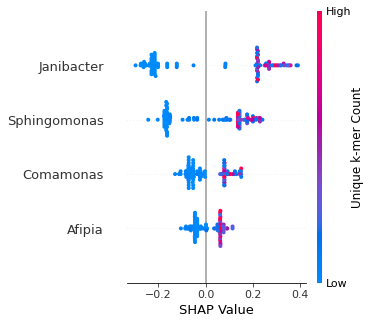

In [18]:
# Get SHAP summary before removing Cellulomonas and Agrobacterium
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=raw_CR, y=y)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_pre = pre_explainer.shap_values(raw_CR)

shap.summary_plot(shap_pre, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'kapusta_pre_shap.png', dpi=600, format='png', bbox_inches='tight')


### Number of Features

In [19]:
print('Neat', X.shape)
print('CR', raw_CR.shape)

Neat (110, 1496)
CR (110, 4)


In [20]:
raw_CR.columns

Index(['Sphingomonas', 'Comamonas', 'Afipia', 'Janibacter'], dtype='object')

## Optimise and evaluate decontaminated models

In [21]:
raw_CR_results, raw_CR_params = optimise_evaluate(raw_CR, y)
# raw_CR_params = {'subsample': 0.7631578947368421, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 426, 'max_depth': 1, 'gamma': 0.0, 'colsample_bytree': 0.1}

RA_CR_results, RA_CR_params = optimise_evaluate(RA_CR, y)
# RA_CR_params = {'subsample': 0.38421052631578945, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 101, 'max_depth': 5, 'gamma': 2.894736842105263, 'colsample_bytree': 0.19473684210526315}

metric_df = metric_df.append(pd.DataFrame({'Raw CR': raw_CR_results, 'RA CR': RA_CR_results}).round(3).T)
display(metric_df)

{'subsample': 0.6, 'scale_pos_weight': 1.0, 'n_estimators': 250, 'max_depth': 4, 'gamma': 3.0, 'colsample_bytree': 0.1473684210526316}
{'subsample': 0.7, 'scale_pos_weight': 1.0, 'n_estimators': 150, 'max_depth': 1, 'gamma': 1.0666666666666667, 'colsample_bytree': 0.38421052631578945}


,test_precision,test_recall,test_F1,test_AUROC
Raw,0.964,0.964,0.964,0.995
RA,1.000,1.000,1.000,1.000
Raw CR,0.950,1.000,0.974,0.992
RA CR,0.840,0.764,0.791,0.916


### Fit clean models

In [22]:
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

RA_CR_model = XGBClassifier(**RA_CR_params)
RA_CR_model.fit(RA_CR, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.38421052631578945,
              gamma=1.0666666666666667, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.0, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

## Interpreting model using SHAP values

### Plot of SHAP values per Feature

In [23]:
import matplotlib.pyplot as plt
explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

#### Dirty raw

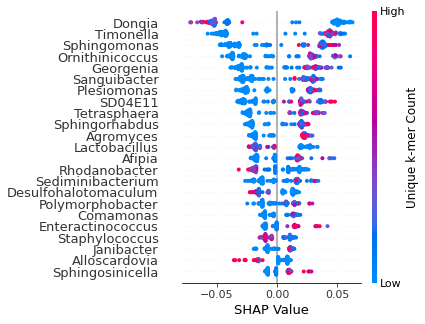

In [24]:
shap.summary_plot(shap_raw, X, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=23)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'kapusta_raw_shap.png', dpi=600, format='png', bbox_inches='tight')

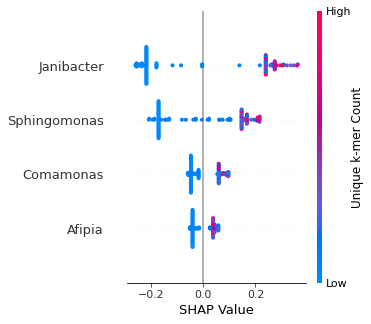

In [25]:
shap.summary_plot(shap_CR, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=35)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'kapusta_raw_CR_shap.png', dpi=600, format='png', bbox_inches='tight')

* Features are ranked by importance from top to botttom
* feature values are the kmer counts for each genus
* SHAP values are the average marginal contributions to probability

### Force plot for healthy patient

In [26]:
dawdawddaw

NameError: name 'dawdawddaw' is not defined

In [ ]:
j = 201

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True)

plt.savefig(results / 'kapusta_CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')

## How much does Escherichia drive predictions?

In Escherichia-positive patients

In [ ]:
n = 10

for i in range(n):
    escherichia = pd.DataFrame(raw_CR.loc[raw_df.pathogen == 'Escherichia coli', :])
    healthy_samples = pd.DataFrame(raw_CR.loc[raw_df.pathogen == 'none', :])
    y_esc = y[raw_df.pathogen == 'Escherichia coli']
    y_healthy = y[raw_df.pathogen == 'none']

    sample_idx = np.random.choice(healthy_samples.index, escherichia.shape[0], replace=False)

    X_esc = escherichia.append(healthy_samples.iloc[sample_idx, :])
    y_esc = y_esc.append(y_healthy[sample_idx])

    # decontam feature space
    with_escherichia_results, with_escherichia_params = optimise_evaluate(X_esc, y_esc)

    # decontam without Escherichia
    no_escherichia_results, no_escherichia_params = optimise_evaluate(X_esc.drop('Escherichia', axis=1), y_esc)

    # Escherichia only
    only_escherichia_results, only_escherichia_params = optimise_evaluate(pd.DataFrame(X_esc['Escherichia']), y_esc)

    esc_metric = pd.DataFrame({'With': with_escherichia_results,
                               'No': no_escherichia_results,
                               'only': only_escherichia_results}).T

    display(esc_metric)
    if i == 0:
        esc_df = esc_metric

    else:
        esc_df = esc_df + esc_metric

In [ ]:
# Average metrics over 10 random samples
esc_df = esc_df / n
display(esc_df)

### Visualise raw model without using Escherichia

In [ ]:
no_esc_model = XGBClassifier(**no_escherichia_params)
no_esc_model.fit(X=X_esc.drop('Escherichia', axis=1), y=y_esc)

no_esc_explainer = shap.TreeExplainer(no_esc_model, 
                                      feature_pertubation='interventional', 
                                      model_output='probability', 
                                      data=X_esc.drop('Escherichia', axis=1))

shap_no_esc = no_esc_explainer.shap_values(X_esc.drop('Escherichia', axis=1))

shap.summary_plot(shap_no_esc, 
                  X_esc.drop('Escherichia', axis=1), 
                  show=False, plot_size=(4, 5), 
                  color_bar_label='Unique k-mer Count', 
                  max_display=25)

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')

plt.savefig(results / 'kapusta_no_esc_shap.png', dpi=600, format='png', bbox_inches='tight')

In [ ]:
display(metric_df)

## Simple decontamination

In [ ]:
import math
from scipy.stats import wilcoxon
import shap


def decontam_simple(X, y):
    to_retain = np.array([True] * X.shape[1])
    p_vals = []
    problems = []
    for i in range(X.shape[1]):
        try:
            genus = X.iloc[:, i].copy()
            pos = genus.loc[y == 1]
            neg = genus.loc[y == 0]
            
            if not (sum(pos != 0) >= 5 and sum(neg != 0) >= 5):
                raise ValueError
            
            # Downsample negative class
            neg = neg.sample(len(pos))
            
            # Wilcoxon test
            _, p_val = wilcoxon(pos, neg, alternative='less')
            p_vals.append(p_val)

            if p_val < 0.05:
                to_retain[i] = False
        
        except ValueError:
            problems.append(X.columns[i])
            to_retain[i] = False
            

    return to_retain, p_vals, problems

In [ ]:
simple_retain, simple_p, problems = decontam_simple(X_RA, y)
print(f'After simple decontamination: {sum(simple_retain)}') # No. of genera retained after simple decontamination

# Remove non-human associated pathogens
retain_names = list(set(X.columns[simple_retain]).intersection(set(meta)))
print(f'After removing non-human pathogens: {len(retain_names)}') # No. of genera retained after simple decontamination

simple_X = X.loc[:, retain_names]

# No. of genera with less than 5 septic and 5 healthy non-zero samples
print(f'No. of problems: {len(problems)}')
print(f'Final list of genera: {retain_names}')

In [ ]:
# Save simple decontam
pd.Series(retain_names).to_csv(datasets / 'kapusta_simple_decontam_pathogens.csv', header=None, index=False)

In [ ]:
simple_results, simple_params = optimise_evaluate(simple_X, y)
metric_df = metric_df.append(pd.DataFrame({'Raw simple': simple_results}).round(3).T)

In [ ]:
simple_model = XGBClassifier(**simple_params)
simple_model.fit(X=simple_X, y=y)

simple_explainer = shap.TreeExplainer(simple_model, feature_pertubation='interventional', 
                                      model_output='probability', 
                                      data=simple_X)

shap_simple = simple_explainer.shap_values(simple_X)

shap.summary_plot(shap_simple, simple_X, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'kapusta_simple_decontam_shap.png', dpi=600, format='png', bbox_inches='tight')

In [ ]:
# Intersecting genera between 
common = len(list(set(to_retain).intersection(set(retain_names))))
print(f'No. of genera in common: {common}')

### Final Results

In [ ]:
display(esc_df)
display(metric_df)

esc_df.to_csv(results / 'kapusta_escherichia_model_results.csv', index=True, header=True)
metric_df.to_csv(results / 'kapusta_model_results.csv', index=True, header=True)